<div class="alert alert-block alert-warning">
<b>⚠⚠⚠ WARNING ⚠⚠⚠</b>   

This notebook can not run with lastest AeroMAPS developments including generic energy models.    
Please refer to v0.9.0-beta to run this notebook.
</div>

## Cost-demand feedback: data exploitation and models testing 

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import gemseo as gm
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from numbers import Number
from typing import Tuple


%matplotlib widget


from aeromaps import create_process
from aeromaps.core.models import (
    models_traffic_cost_feedback,
    models_efficiency_top_down,
    models_energy_without_fuel_effect,
    models_offset,
    models_climate_simple_gwpstar,
    models_sustainability,
    models_energy_cost_simple,
    models_operation_cost_top_down_feedback,
)
from aeromaps.models.base import (
    AeroMAPSModel,
    aeromaps_leveling_function,
)

from aeromaps.utils.functions import custom_logger_config

custom_logger_config(gm.configure_logger())

# load standard models and remove those replaced in the tests
models_operation_cost_top_down_feedback.pop("passenger_aircraft_marginal_cost")
models = {
    "models_traffic_cost_feedback": models_traffic_cost_feedback,
    "models_efficiency_top_down": models_efficiency_top_down,
    "models_energy_without_fuel_effect": models_energy_without_fuel_effect,
    "models_offset": models_offset,
    "models_climate_simple_gwpstar": models_climate_simple_gwpstar,
    "models_sustainability": models_sustainability,
    "models_energy_cost_simple": models_energy_cost_simple,
    "models_operation_cost_top_down_feedback": models_operation_cost_top_down_feedback,
}


# load traffic data
df = pd.read_excel(
    "./../../../resources/cost_data/IATA_cost_data.xlsx", sheet_name="Exploration", index_col=0
)


df = df.head(22)
df_t = df.T
df_t

In [ ]:
# inflation rates https://data.worldbank.org/indicator/FP.CPI.TOTL.ZG?end=2024&locations=1W&start=1981&view=chart

# Inflation rates for 1981–2024
inflation_rates = [
    12.44243689,
    10.22172714,
    8.669271598,
    8.080320173,
    6.807566558,
    5.822666962,
    5.710119385,
    7.113406529,
    6.923905037,
    8.063460909,
    8.996938735,
    7.636108523,
    7.144587069,
    10.24793556,
    9.077380952,
    6.526095694,
    5.554129889,
    5.097291493,
    3.041946671,
    3.433515634,
    3.836572621,
    2.90799857,
    3.025045263,
    3.517999031,
    4.107250707,
    4.267174634,
    4.810237043,
    8.949953354,
    2.860448559,
    3.326344634,
    4.82239636,
    3.725326661,
    2.651673429,
    2.354490528,
    1.443857193,
    1.605539174,
    2.254276519,
    2.442583297,
    2.206073058,
    1.905663587,
    3.475403203,
    7.922048831,
    5.870102688,
    3.01447577,
    3,
]


years = list(range(1980, 2026))


cpi_values = [100]

# Build CPI series
for rate in inflation_rates:
    prev_cpi = cpi_values[-1]
    new_cpi = prev_cpi * (1 + rate / 100)
    cpi_values.append(new_cpi)

# Align CPI series with years
cpi_series = pd.Series(cpi_values, index=years)


# Reference CPI for 2020
deflator_2020 = cpi_series.loc[2020] / cpi_series


df_t["deflator_2020"] = deflator_2020.loc[df_t.index]

df_t["Real avg price (incl. anx), $/RPK"] = (
    df_t["Avg price (incl. anx), $/RPK"] * df_t["deflator_2020"]
)
df_t["Real avg cost, $/RPK"] = df_t["Avg cost, $/RPK"] * df_t["deflator_2020"]

In [ ]:
fig = plt.figure(figsize=(10, 6))

plt.plot(df_t.index, df_t["Avg price (incl. anx), $/RPK"], label="Price (Nominal)", color="#cb3629")
plt.plot(df_t.index, df_t["Avg cost, $/RPK"], label="Cost (Nominal)", color="#092054")

plt.plot(
    df_t.index,
    df_t["Real avg price (incl. anx), $/RPK"],
    label="Price (Real)",
    color="#cb3629",
    ls="--",
)
plt.plot(df_t.index, df_t["Real avg cost, $/RPK"], label="Cost (Real)", color="#092054", ls="--")

plt.xlabel("")
plt.ylim(
    0,
)
plt.legend()

In [ ]:
df_t.drop([2020, 2022, 2021], inplace=True)

Compute a corrected price with actual IATA markup but AeroMAPS 2019 total cost

In [ ]:
df_t["normalised_price"] = df_t["Real avg price (incl. anx), $/RPK"] / 1.14 - (
    df_t["Real avg cost, $/RPK"] / 1.14 - 0.08853131471704129
)
# from aeromaps
euro_dollar = 1.14
intial_total_cost_per_rpk_without_extra_tax = 0.08853131471704129

In [ ]:
df_t["normalised_price"]

## Models comparison 


Two options are explored as potential supply models
 - a) Consider the initial corrected price as a baseline, use baseline growth rpk to correct as to have user's default growth when 2019 conditions remain trhough the scenario
 - b) Consider a fixed supply function determined on average past conditions, demand adjusted to match with equilibrium price as to have user's default growth when 2019 conditions remain trhough the scenario
 - c) Fixed (average) markup
 - d) Fixed (average) margin

In both a) and b) cases the idea is to have a linear inverse suppy function f(Q), which can be entirely determined base on initial (or historical) cost and price values

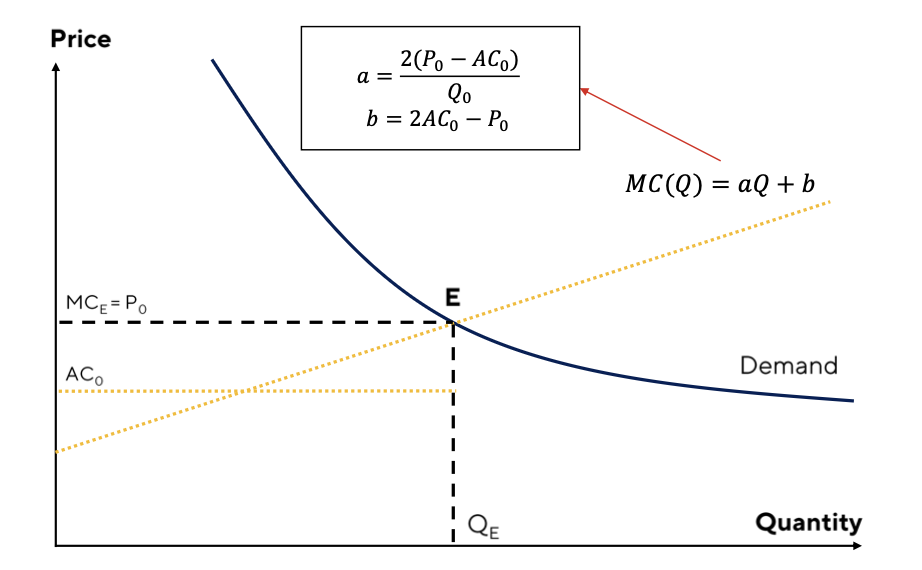

## a) Historical price/volume callibration
The idea is to keep the historical price to callibrate the supply function, but to adjust the function to match the desired RPK.
Technically, it means that teh whole industry scales up without affecting the cost structure to match an increasing exogenous demand. 

In [ ]:
average_normalised_price = df_t["normalised_price"].mean()

In [ ]:
average_normalised_price

In [ ]:
class PassengerAircraftMarginalCostA(AeroMAPSModel):
    def __init__(self, name="passenger_aircraft_marginal_cost", fleet_model=None, *args, **kwargs):
        super().__init__(name=name, *args, **kwargs)

    def compute(
        self,
        rpk: pd.Series,
        rpk_no_elasticity: pd.Series,
        total_cost_per_rpk_without_extra_tax: pd.Series,
        total_extra_tax_per_rpk: pd.Series,
    ) -> Tuple[
        pd.Series,
        pd.Series,
        pd.Series,
    ]:
        intial_total_cost_per_rpk_without_extra_tax = total_cost_per_rpk_without_extra_tax[
            self.prospection_start_year - 1
        ]

        # Were defining the inverse market-level suppy function ( cost =f (rpk) ) as a linear function by hypothesis
        # Calibration of this function is done base on average cost and prices for the last 20 years of IATA data (2020,2021,2022 excluded)

        b = 2 * intial_total_cost_per_rpk_without_extra_tax - average_normalised_price
        a = (
            2
            * (average_normalised_price - intial_total_cost_per_rpk_without_extra_tax)
            / rpk_no_elasticity
        )

        # For latter update replace total cost by the step component of the marginal cost.
        marginal_cost_per_rpk = (
            a * rpk.loc[self.prospection_start_year : self.end_year]
            + b
            + total_cost_per_rpk_without_extra_tax.loc[self.prospection_start_year : self.end_year]
            - intial_total_cost_per_rpk_without_extra_tax
        )

        avg_cst = (
            marginal_cost_per_rpk
            + b
            + total_cost_per_rpk_without_extra_tax.loc[self.prospection_start_year : self.end_year]
            - intial_total_cost_per_rpk_without_extra_tax
        ) / 2

        margin_per_rpk = marginal_cost_per_rpk - avg_cst
        margin = margin_per_rpk * rpk

        airfare_per_rpk_true = marginal_cost_per_rpk + total_extra_tax_per_rpk
        airfare_per_rpk_true = airfare_per_rpk_true
        airfare_per_rpk = airfare_per_rpk_true

        self.df.loc[:, "marginal_cost_per_rpk"] = marginal_cost_per_rpk
        self.df.loc[:, "airfare_per_rpk"] = airfare_per_rpk
        self.df.loc[:, "margin_per_rpk"] = margin_per_rpk
        self.df.loc[:, "avg_cost"] = avg_cst
        self.df.loc[:, "margin"] = margin

        return (marginal_cost_per_rpk, airfare_per_rpk_true, airfare_per_rpk)

In [ ]:
models_opt_a = copy.deepcopy(models)
models_opt_a["passenger_aircraft_marginal_cost"] = PassengerAircraftMarginalCostA(
    "passenger_aircraft_marginal_cost"
)

process_a = create_process(
    custom_models=models_opt_a,
)

In [ ]:
# Default ("business as usual" --> in our case considering frozen technology in 2019 and 100% kerozene) Air traffic evolution

process_a.parameters.energy_per_ask_short_range_dropin_fuel_gain_reference_years = []
process_a.parameters.energy_per_ask_short_range_dropin_fuel_gain_reference_years_values = [
    0.0000000001
]
process_a.parameters.energy_per_ask_medium_range_dropin_fuel_gain_reference_years = []
process_a.parameters.energy_per_ask_medium_range_dropin_fuel_gain_reference_years_values = [
    0.0000000001
]
process_a.parameters.energy_per_ask_long_range_dropin_fuel_gain_reference_years = []
process_a.parameters.energy_per_ask_long_range_dropin_fuel_gain_reference_years_values = [
    0.0000000001
]
process_a.parameters.operations_final_gain = 0.0000000001  # [%]
process_a.parameters.operations_start_year = 2025
process_a.parameters.operations_duration = 25.0
process_a.parameters.load_factor_end_year = 82.39931200000001
process_a.parameters.carbon_tax_reference_years = [2020, 2034, 2035, 2050]
process_a.parameters.carbon_tax_reference_years_values = [0, 0, 300, 300]

process_a.parameters.kerosene_price_reference_years = [2020, 2039, 2040, 2050]
process_a.parameters.kerosene_price_reference_years_values = [0.41, 0.41, 1.2, 1.2]

# With the eleasticity there is a coupling llop bewteen airfare and traffic.
# The solver needs to enter in the loop at some point, and thus some coupling varaibles needs to have a default value. If not done in the models, one can do it here or in the input files.

process_a.parameters.airfare_per_rpk = pd.Series(
    0.09251431471704129,
    index=range(process_a.parameters.historic_start_year, process_a.parameters.end_year + 1),
)
process_a.parameters.price_elasticity = -0.9

In [ ]:
process_a.compute()

## b) Historical function + future volume callibration
The idea is to keep the historical supply function, before tuning the isoelastic demand to match that point (it's rthe only degree of freedom we have as supply is fixed).
Technically, it means that the industry increase its marginal cost (BEFORE CONSIDERING EFFICIENCY) to match an increasing demand. As initial demand stays the same with an increasing "initial" price, it becomes less price sensitive. 

In [ ]:
a = (
    2
    * (df_t["normalised_price"] - intial_total_cost_per_rpk_without_extra_tax)
    / df_t["RPKs, billion"]
)

In [ ]:
b = 2 * intial_total_cost_per_rpk_without_extra_tax - df_t["normalised_price"]

In [ ]:
x = np.linspace(3000, 12000, 500)
Y = np.array([slope * x + intercept for slope, intercept in zip(a, b)])

# Mean and standard deviation across functions
y_mean = Y.mean(axis=0)
y_std = Y.std(axis=0)

mean_slope = np.mean(a)
mean_intercept = np.mean(b)


sns.set(style="whitegrid")
line_color = sns.color_palette("deep")[0]
fill_color = sns.color_palette("deep")[0]
individual_line_color = sns.color_palette("gray")[2]

plt.figure(figsize=(10, 6))

for y in Y:
    plt.plot(x, y, color=individual_line_color, alpha=0.2, linewidth=1)

# Plot mean line
plt.plot(x, y_mean, color=line_color, linewidth=2, label="Mean Function")

# Fill ±1 std deviation
plt.fill_between(
    x, y_mean - y_std, y_mean + y_std, color=fill_color, alpha=0.2, label="±1 std deviation"
)


equation_text = rf"$y = {mean_slope:.2e} \cdot x + {mean_intercept:.2e}$"
plt.text(
    0.98,
    0.95,
    equation_text,
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment="top",
    horizontalalignment="right",
    bbox=dict(boxstyle="round,pad=0.4", facecolor="white", edgecolor="lightgrey", linewidth=1.2),
)


x_marker = df_t["RPKs, billion"]
y_marker = df_t["normalised_price"]
palette = sns.color_palette("viridis", len(a))
for i, (year, valx, valy) in enumerate(zip(df_t.index, x_marker, y_marker)):
    plt.scatter(valx, valy, color=palette[i], edgecolor="black", zorder=5)
    plt.text(valx + 151, valy - 0.0001, str(year), fontsize=10, va="center")


plt.xlabel("x", fontsize=12)
plt.ylabel("y", fontsize=12)
plt.title("Inverse offer function callibration, option b", fontsize=14)
plt.ylim(0.08, 0.11)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

The function seems to match well historical data on which it is callibrated.

In [ ]:
class PassengerAircraftMarginalCostB(AeroMAPSModel):
    def __init__(self, name="passenger_aircraft_marginal_cost", fleet_model=None, *args, **kwargs):
        super().__init__(name=name, *args, **kwargs)

    def compute(
        self,
        rpk: pd.Series,
        rpk_no_elasticity: pd.Series,
        total_cost_per_rpk_without_extra_tax: pd.Series,
        total_extra_tax_per_rpk: pd.Series,
    ) -> Tuple[pd.Series, pd.Series, pd.Series, pd.Series]:
        intial_total_cost_per_rpk_without_extra_tax = total_cost_per_rpk_without_extra_tax[
            self.prospection_start_year - 1
        ]

        # Were defining the inverse market-level suppy function ( cost =f (rpk) ) as a linear function by hypothesis
        # Calibration of this function is done base on average cost and prices for the last 20 years of IATA data (2020,2021,2022 excluded)

        b = mean_intercept
        a = mean_slope

        # For latter update replace total cost by the step component of the marginal cost.
        marginal_cost_per_rpk = (
            a * rpk.loc[self.prospection_start_year : self.end_year] / 1e9
            + b
            + total_cost_per_rpk_without_extra_tax.loc[self.prospection_start_year : self.end_year]
            - intial_total_cost_per_rpk_without_extra_tax
        )

        avg_cst = (
            marginal_cost_per_rpk
            + b
            + total_cost_per_rpk_without_extra_tax.loc[self.prospection_start_year : self.end_year]
            - intial_total_cost_per_rpk_without_extra_tax
        ) / 2

        margin_per_rpk = marginal_cost_per_rpk - avg_cst
        margin = margin_per_rpk * rpk

        marginal_cost_per_rpk_base = (
            a * rpk_no_elasticity.loc[self.prospection_start_year : self.end_year] / 1e9 + b
        )

        airfare_per_rpk_true = marginal_cost_per_rpk + total_extra_tax_per_rpk
        airfare_per_rpk = airfare_per_rpk_true

        airfare_per_rpk_base = (
            marginal_cost_per_rpk_base + total_extra_tax_per_rpk[self.prospection_start_year - 1]
        )

        self.df.loc[:, "marginal_cost_per_rpk"] = marginal_cost_per_rpk
        self.df.loc[:, "airfare_per_rpk"] = airfare_per_rpk
        self.df.loc[:, "airfare_per_rpk_base"] = airfare_per_rpk_base
        self.df.loc[:, "margin_per_rpk"] = margin_per_rpk
        self.df.loc[:, "avg_cost"] = avg_cst
        self.df.loc[:, "margin"] = margin

        return (marginal_cost_per_rpk, airfare_per_rpk_true, airfare_per_rpk, airfare_per_rpk_base)

In [ ]:
class RPKWithElasticityB(AeroMAPSModel):
    def __init__(self, name="rpk_with_elasticity", *args, **kwargs):
        super().__init__(name=name, *args, **kwargs)

    def compute(
        self,
        rpk_init: pd.Series,
        short_range_rpk_share_2019: float,
        medium_range_rpk_share_2019: float,
        long_range_rpk_share_2019: float,
        covid_start_year: Number,
        covid_rpk_drop_start_year: float,
        covid_end_year_passenger: Number,
        covid_end_year_reference_rpk_ratio: float,
        cagr_passenger_short_range_reference_periods: list,
        cagr_passenger_short_range_reference_periods_values: list,
        cagr_passenger_medium_range_reference_periods: list,
        cagr_passenger_medium_range_reference_periods_values: list,
        cagr_passenger_long_range_reference_periods: list,
        cagr_passenger_long_range_reference_periods_values: list,
        rpk_short_range_measures_impact: pd.Series,
        rpk_medium_range_measures_impact: pd.Series,
        rpk_long_range_measures_impact: pd.Series,
        airfare_per_rpk: pd.Series,
        airfare_per_rpk_base: pd.Series,
        price_elasticity: float,
    ) -> Tuple[
        pd.Series,
        pd.Series,
        pd.Series,
        pd.Series,
        pd.Series,
        pd.Series,
        pd.Series,
        pd.Series,
        pd.Series,
        pd.Series,
        pd.Series,
        pd.Series,
        float,
        float,
        float,
        float,
        float,
        float,
        float,
        float,
    ]:
        """Update RPK based on cost increase calculation."""

        # Initialization based on 2019 share
        for k in range(self.historic_start_year, self.prospection_start_year):
            self.df.loc[k, "rpk_short_range"] = short_range_rpk_share_2019 / 100 * rpk_init.loc[k]
            self.df.loc[k, "rpk_medium_range"] = medium_range_rpk_share_2019 / 100 * rpk_init.loc[k]
            self.df.loc[k, "rpk_long_range"] = long_range_rpk_share_2019 / 100 * rpk_init.loc[k]

        # Covid functions
        reference_years = [covid_start_year, covid_end_year_passenger]
        reference_values_covid = [
            1 - covid_rpk_drop_start_year / 100,
            covid_end_year_reference_rpk_ratio / 100,
        ]
        covid_function = interp1d(reference_years, reference_values_covid, kind="linear")

        # CAGR function
        ## Short range
        annual_growth_rate_passenger_short_range_prospective = aeromaps_leveling_function(
            self,
            cagr_passenger_short_range_reference_periods,
            cagr_passenger_short_range_reference_periods_values,
            model_name=self.name,
        )
        self.df.loc[:, "annual_growth_rate_passenger_short_range"] = (
            annual_growth_rate_passenger_short_range_prospective
        )
        ## Medium range
        annual_growth_rate_passenger_medium_range_prospective = aeromaps_leveling_function(
            self,
            cagr_passenger_medium_range_reference_periods,
            cagr_passenger_medium_range_reference_periods_values,
            model_name=self.name,
        )
        self.df.loc[:, "annual_growth_rate_passenger_medium_range"] = (
            annual_growth_rate_passenger_medium_range_prospective
        )
        ## Long range
        annual_growth_rate_passenger_long_range_prospective = aeromaps_leveling_function(
            self,
            cagr_passenger_long_range_reference_periods,
            cagr_passenger_long_range_reference_periods_values,
            model_name=self.name,
        )
        self.df.loc[:, "annual_growth_rate_passenger_long_range"] = (
            annual_growth_rate_passenger_long_range_prospective
        )

        # Short range
        for k in range(covid_start_year, covid_end_year_passenger + 1):
            self.df.loc[k, "rpk_short_range"] = self.df.loc[
                covid_start_year - 1, "rpk_short_range"
            ] * covid_function(k)

        for k in range(covid_end_year_passenger + 1, self.end_year + 1):
            self.df.loc[k, "rpk_short_range"] = self.df.loc[k - 1, "rpk_short_range"] * (
                1 + self.df.loc[k, "annual_growth_rate_passenger_short_range"] / 100
            )

        rpk_short_range_no_elasticity = self.df.loc[:, "rpk_short_range"].copy()

        # Medium range
        for k in range(covid_start_year, covid_end_year_passenger + 1):
            self.df.loc[k, "rpk_medium_range"] = self.df.loc[
                covid_start_year - 1, "rpk_medium_range"
            ] * covid_function(k)
        for k in range(covid_end_year_passenger + 1, self.end_year + 1):
            self.df.loc[k, "rpk_medium_range"] = self.df.loc[k - 1, "rpk_medium_range"] * (
                1 + self.df.loc[k, "annual_growth_rate_passenger_medium_range"] / 100
            )

        rpk_medium_range_no_elasticity = self.df.loc[:, "rpk_medium_range"].copy()

        # Long range
        for k in range(covid_start_year, covid_end_year_passenger + 1):
            self.df.loc[k, "rpk_long_range"] = self.df.loc[
                covid_start_year - 1, "rpk_long_range"
            ] * covid_function(k)
        for k in range(covid_end_year_passenger + 1, self.end_year + 1):
            self.df.loc[k, "rpk_long_range"] = self.df.loc[k - 1, "rpk_long_range"] * (
                1 + self.df.loc[k, "annual_growth_rate_passenger_long_range"] / 100
            )

        rpk_long_range_no_elasticity = self.df.loc[:, "rpk_long_range"].copy()

        self.df.loc[:, "rpk_short_range_no_elasticity"] = rpk_short_range_no_elasticity
        self.df.loc[:, "rpk_medium_range_no_elasticity"] = rpk_medium_range_no_elasticity
        self.df.loc[:, "rpk_long_range_no_elasticity"] = rpk_long_range_no_elasticity

        for k in range(self.historic_start_year, self.prospection_start_year):
            self.df.loc[k, "rpk_no_elasticity"] = rpk_init.loc[k]
        for k in range(self.prospection_start_year, self.end_year + 1):
            self.df.loc[k, "rpk_no_elasticity"] = (
                self.df.loc[k, "rpk_short_range_no_elasticity"]
                + self.df.loc[k, "rpk_medium_range_no_elasticity"]
                + self.df.loc[k, "rpk_long_range_no_elasticity"]
            )
        rpk_no_elasticity = self.df["rpk_no_elasticity"]

        self.df.loc[self.historic_start_year : covid_end_year_passenger, "rpk"] = (
            rpk_no_elasticity.loc[self.historic_start_year : covid_end_year_passenger]
        )

        self.df.loc[covid_end_year_passenger + 1 : self.end_year, "rpk"] = (
            rpk_no_elasticity
            / (
                airfare_per_rpk_base.loc[covid_end_year_passenger + 1 : self.end_year]
                ** price_elasticity
            )
            * (
                airfare_per_rpk.loc[covid_end_year_passenger + 1 : self.end_year]
                ** price_elasticity
            )
        )

        rpk_short_range = self.df["rpk_short_range"] * self.df["rpk"] / rpk_no_elasticity
        rpk_medium_range = self.df["rpk_medium_range"] * self.df["rpk"] / rpk_no_elasticity
        rpk_long_range = self.df["rpk_long_range"] * self.df["rpk"] / rpk_no_elasticity

        # TODO discuss if that should be considered for surplus destruction. I think so => not inlcluded in rpk_no_elasticity
        rpk_short_range = rpk_short_range * rpk_short_range_measures_impact
        rpk_medium_range = rpk_medium_range * rpk_medium_range_measures_impact
        rpk_long_range = rpk_long_range * rpk_long_range_measures_impact

        self.df.loc[:, "rpk_short_range"] = rpk_short_range
        self.df.loc[:, "rpk_medium_range"] = rpk_medium_range
        self.df.loc[:, "rpk_long_range"] = rpk_long_range

        # Total
        for k in range(self.historic_start_year, self.prospection_start_year):
            self.df.loc[k, "rpk"] = rpk_init.loc[k]
        for k in range(self.prospection_start_year, self.end_year + 1):
            self.df.loc[k, "rpk"] = (
                self.df.loc[k, "rpk_short_range"]
                + self.df.loc[k, "rpk_medium_range"]
                + self.df.loc[k, "rpk_long_range"]
            )
        rpk = self.df["rpk"]

        # Annual growth rate
        for k in range(self.historic_start_year + 1, self.prospection_start_year):
            self.df.loc[k, "annual_growth_rate_passenger_short_range"] = (
                self.df.loc[k, "rpk_short_range"] / self.df.loc[k - 1, "rpk_short_range"] - 1
            ) * 100
        for k in range(self.historic_start_year + 1, self.prospection_start_year):
            self.df.loc[k, "annual_growth_rate_passenger_short_range"] = (
                self.df.loc[k, "rpk_medium_range"] / self.df.loc[k - 1, "rpk_medium_range"] - 1
            ) * 100
        for k in range(self.historic_start_year + 1, self.prospection_start_year):
            self.df.loc[k, "annual_growth_rate_passenger_long_range"] = (
                self.df.loc[k, "rpk_long_range"] / self.df.loc[k - 1, "rpk_long_range"] - 1
            ) * 100
        for k in range(self.historic_start_year + 1, self.end_year + 1):
            self.df.loc[k, "annual_growth_rate_passenger"] = (
                self.df.loc[k, "rpk"] / self.df.loc[k - 1, "rpk"] - 1
            ) * 100

        annual_growth_rate_passenger_short_range = self.df[
            "annual_growth_rate_passenger_short_range"
        ]
        annual_growth_rate_passenger_medium_range = self.df[
            "annual_growth_rate_passenger_medium_range"
        ]
        annual_growth_rate_passenger_long_range = self.df["annual_growth_rate_passenger_long_range"]
        annual_growth_rate_passenger = self.df["annual_growth_rate_passenger"]

        # Compound Annual Growth Rate (CAGR)
        cagr_rpk_short_range = 100 * (
            (
                self.df.loc[self.end_year, "rpk_short_range"]
                / self.df.loc[self.prospection_start_year - 1, "rpk_short_range"]
            )
            ** (1 / (self.end_year - self.prospection_start_year))
            - 1
        )
        cagr_rpk_medium_range = 100 * (
            (
                self.df.loc[self.end_year, "rpk_medium_range"]
                / self.df.loc[self.prospection_start_year - 1, "rpk_medium_range"]
            )
            ** (1 / (self.end_year - self.prospection_start_year))
            - 1
        )
        cagr_rpk_long_range = 100 * (
            (
                self.df.loc[self.end_year, "rpk_long_range"]
                / self.df.loc[self.prospection_start_year - 1, "rpk_long_range"]
            )
            ** (1 / (self.end_year - self.prospection_start_year))
            - 1
        )
        cagr_rpk = 100 * (
            (
                self.df.loc[self.end_year, "rpk"]
                / self.df.loc[self.prospection_start_year - 1, "rpk"]
            )
            ** (1 / (self.end_year - self.prospection_start_year))
            - 1
        )

        # Prospective evolution of RPK (between prospection_start_year-1 and end_year)
        prospective_evolution_rpk_short_range = 100 * (
            self.df.loc[self.end_year, "rpk_short_range"]
            / self.df.loc[self.prospection_start_year - 1, "rpk_short_range"]
            - 1
        )
        prospective_evolution_rpk_medium_range = 100 * (
            self.df.loc[self.end_year, "rpk_medium_range"]
            / self.df.loc[self.prospection_start_year - 1, "rpk_medium_range"]
            - 1
        )
        prospective_evolution_rpk_long_range = 100 * (
            self.df.loc[self.end_year, "rpk_long_range"]
            / self.df.loc[self.prospection_start_year - 1, "rpk_long_range"]
            - 1
        )
        prospective_evolution_rpk = 100 * (
            self.df.loc[self.end_year, "rpk"] / self.df.loc[self.prospection_start_year - 1, "rpk"]
            - 1
        )

        self.float_outputs["cagr_rpk_short_range"] = cagr_rpk_short_range
        self.float_outputs["cagr_rpk_medium_range"] = cagr_rpk_medium_range
        self.float_outputs["cagr_rpk_long_range"] = cagr_rpk_long_range
        self.float_outputs["cagr_rpk"] = cagr_rpk
        self.float_outputs["prospective_evolution_rpk_short_range"] = (
            prospective_evolution_rpk_short_range
        )
        self.float_outputs["prospective_evolution_rpk_medium_range"] = (
            prospective_evolution_rpk_medium_range
        )
        self.float_outputs["prospective_evolution_rpk_long_range"] = (
            prospective_evolution_rpk_long_range
        )
        self.float_outputs["prospective_evolution_rpk"] = prospective_evolution_rpk

        # print('In PriceElasticity: Airfare 2050:{}, RPK 2050:{}'.format(airfare_per_rpk[self.end_year], rpk[self.end_year]))

        return (
            rpk_short_range,
            rpk_medium_range,
            rpk_long_range,
            rpk,
            rpk_no_elasticity,
            rpk_short_range_no_elasticity,
            rpk_medium_range_no_elasticity,
            rpk_long_range_no_elasticity,
            annual_growth_rate_passenger_short_range,
            annual_growth_rate_passenger_medium_range,
            annual_growth_rate_passenger_long_range,
            annual_growth_rate_passenger,
            cagr_rpk_short_range,
            cagr_rpk_medium_range,
            cagr_rpk_long_range,
            cagr_rpk,
            prospective_evolution_rpk_short_range,
            prospective_evolution_rpk_medium_range,
            prospective_evolution_rpk_long_range,
            prospective_evolution_rpk,
        )

In [ ]:
models_opt_b = copy.deepcopy(models)

models_opt_b["models_traffic_cost_feedback"].pop("rpk_with_elasticity")
models_opt_b["passenger_aircraft_marginal_cost"] = PassengerAircraftMarginalCostB(
    "passenger_aircraft_marginal_cost"
)
models_opt_b["rpk_with_elasticity"] = RPKWithElasticityB("rpk_with_elasticity")

process_b = create_process(
    custom_models=models_opt_b,
)

In [ ]:
process_b.parameters.energy_per_ask_short_range_dropin_fuel_gain_reference_years = []
process_b.parameters.energy_per_ask_short_range_dropin_fuel_gain_reference_years_values = [
    0.0000000001
]
process_b.parameters.energy_per_ask_medium_range_dropin_fuel_gain_reference_years = []
process_b.parameters.energy_per_ask_medium_range_dropin_fuel_gain_reference_years_values = [
    0.0000000001
]
process_b.parameters.energy_per_ask_long_range_dropin_fuel_gain_reference_years = []
process_b.parameters.energy_per_ask_long_range_dropin_fuel_gain_reference_years_values = [
    0.0000000001
]
process_b.parameters.operations_final_gain = 0.0000000001  # [%]
process_b.parameters.operations_start_year = 2025
process_b.parameters.operations_duration = 25.0
process_b.parameters.load_factor_end_year = 82.39931200000001
process_b.parameters.carbon_tax_reference_years = [2020, 2034, 2035, 2050]
process_b.parameters.carbon_tax_reference_years_values = [0, 0, 300, 300]

process_b.parameters.kerosene_price_reference_years = [2020, 2039, 2040, 2050]
process_b.parameters.kerosene_price_reference_years_values = [0.41, 0.41, 1.2, 1.2]

# With the eleasticity there is a coupling llop bewteen airfare and traffic.
# The solver needs to enter in the loop at some point, and thus some coupling varaibles needs to have a default value. If not done in the models, one can do it here or in the input files.

process_b.parameters.airfare_per_rpk = pd.Series(
    0.09251431471704129,
    index=range(process_b.parameters.historic_start_year, process_b.parameters.end_year + 1),
)

process_b.parameters.airfare_per_rpk_base = pd.Series(
    0.09251431471704129,
    index=range(process_b.parameters.historic_start_year, process_b.parameters.end_year + 1),
)
process_b.parameters.price_elasticity = -0.9

In [ ]:
process_b.compute()

In [ ]:
class PassengerAircraftMarginalCostC(AeroMAPSModel):
    def __init__(self, name="passenger_aircraft_marginal_cost", fleet_model=None, *args, **kwargs):
        super().__init__(name=name, *args, **kwargs)

    def compute(
        self,
        markup: float,
        rpk: pd.Series,
        total_cost_per_rpk_without_extra_tax: pd.Series,
        total_extra_tax_per_rpk: pd.Series,
    ) -> Tuple[
        pd.Series,
        pd.Series,
    ]:
        marginal_cost_per_rpk = total_cost_per_rpk_without_extra_tax
        airfare_per_rpk_true = (
            total_cost_per_rpk_without_extra_tax + total_extra_tax_per_rpk + markup
        )

        airfare_per_rpk = airfare_per_rpk_true.loc[2020:2050]

        self.df.loc[:, "airfare_per_rpk"] = airfare_per_rpk
        self.df.loc[:, "margin_per_rpk"] = markup
        self.df.loc[:, "margin"] = markup * rpk

        return (marginal_cost_per_rpk, airfare_per_rpk)

In [ ]:
models_opt_c = copy.deepcopy(models)

models_opt_c["passenger_aircraft_marginal_cost"] = PassengerAircraftMarginalCostC(
    "passenger_aircraft_marginal_cost"
)

process_c = create_process(
    custom_models=models_opt_c,
)

In [ ]:
process_c.parameters.energy_per_ask_short_range_dropin_fuel_gain_reference_years = []
process_c.parameters.energy_per_ask_short_range_dropin_fuel_gain_reference_years_values = [
    0.0000000001
]
process_c.parameters.energy_per_ask_medium_range_dropin_fuel_gain_reference_years = []
process_c.parameters.energy_per_ask_medium_range_dropin_fuel_gain_reference_years_values = [
    0.0000000001
]
process_c.parameters.energy_per_ask_long_range_dropin_fuel_gain_reference_years = []
process_c.parameters.energy_per_ask_long_range_dropin_fuel_gain_reference_years_values = [
    0.0000000001
]
process_c.parameters.operations_final_gain = 0.0000000001  # [%]
process_c.parameters.operations_start_year = 2025
process_c.parameters.operations_duration = 25.0
process_c.parameters.load_factor_end_year = 82.39931200000001
process_c.parameters.carbon_tax_reference_years = [2020, 2034, 2035, 2050]
process_c.parameters.carbon_tax_reference_years_values = [0, 0, 300, 300]

process_c.parameters.kerosene_price_reference_years = [2020, 2039, 2040, 2050]
process_c.parameters.kerosene_price_reference_years_values = [0.41, 0.41, 1.2, 1.2]

# With the eleasticity there is a coupling llop bewteen airfare and traffic.
# The solver needs to enter in the loop at some point, and thus some coupling varaibles needs to have a default value. If not done in the models, one can do it here or in the input files.

process_c.parameters.airfare_per_rpk = pd.Series(
    0.09251431471704129,
    index=range(process_c.parameters.historic_start_year, process_c.parameters.end_year + 1),
)


process_c.parameters.price_elasticity = -0.9

process_c.parameters.markup = (
    df_t["Avg price (incl. anx), $/RPK"] - df_t["Avg cost, $/RPK"]
).mean()

In [ ]:
process_c.compute()

In [ ]:
class PassengerAircraftMarginalCostD(AeroMAPSModel):
    def __init__(self, name="passenger_aircraft_marginal_cost", fleet_model=None, *args, **kwargs):
        super().__init__(name=name, *args, **kwargs)

    def compute(
        self,
        markup: float,
        rpk: pd.Series,
        total_cost_per_rpk_without_extra_tax: pd.Series,
        total_extra_tax_per_rpk: pd.Series,
    ) -> Tuple[
        pd.Series,
        pd.Series,
    ]:
        marginal_cost_per_rpk = total_cost_per_rpk_without_extra_tax
        airfare_per_rpk_true = (
            total_cost_per_rpk_without_extra_tax * (1 + markup) + total_extra_tax_per_rpk
        )

        airfare_per_rpk = airfare_per_rpk_true.loc[2020:2050]

        self.df.loc[:, "airfare_per_rpk"] = airfare_per_rpk
        self.df.loc[:, "margin_per_rpk"] = total_cost_per_rpk_without_extra_tax * markup
        self.df.loc[:, "margin"] = total_cost_per_rpk_without_extra_tax * markup * rpk

        return (marginal_cost_per_rpk, airfare_per_rpk)

In [ ]:
models_opt_d = copy.deepcopy(models)

models_opt_d["passenger_aircraft_marginal_cost"] = PassengerAircraftMarginalCostD(
    "passenger_aircraft_marginal_cost"
)

process_d = create_process(
    custom_models=models_opt_d,
)

In [ ]:
process_d.parameters.energy_per_ask_short_range_dropin_fuel_gain_reference_years = []
process_d.parameters.energy_per_ask_short_range_dropin_fuel_gain_reference_years_values = [
    0.0000000001
]
process_d.parameters.energy_per_ask_medium_range_dropin_fuel_gain_reference_years = []
process_d.parameters.energy_per_ask_medium_range_dropin_fuel_gain_reference_years_values = [
    0.0000000001
]
process_d.parameters.energy_per_ask_long_range_dropin_fuel_gain_reference_years = []
process_d.parameters.energy_per_ask_long_range_dropin_fuel_gain_reference_years_values = [
    0.0000000001
]
process_d.parameters.operations_final_gain = 0.0000000001  # [%]
process_d.parameters.operations_start_year = 2025
process_d.parameters.operations_duration = 25.0
process_d.parameters.load_factor_end_year = 82.39931200000001
process_d.parameters.carbon_tax_reference_years = [2020, 2034, 2035, 2050]
process_d.parameters.carbon_tax_reference_years_values = [0, 0, 300, 300]

process_d.parameters.kerosene_price_reference_years = [2020, 2039, 2040, 2050]
process_d.parameters.kerosene_price_reference_years_values = [0.41, 0.41, 1.2, 1.2]

# With the eleasticity there is a coupling llop bewteen airfare and traffic.
# The solver needs to enter in the loop at some point, and thus some coupling varaibles needs to have a default value. If not done in the models, one can do it here or in the input files.

process_d.parameters.airfare_per_rpk = pd.Series(
    0.09251431471704129,
    index=range(process_d.parameters.historic_start_year, process_d.parameters.end_year + 1),
)


process_d.parameters.price_elasticity = -0.9

process_d.parameters.markup = df_t["% gross margin"].mean() / 100

In [ ]:
process_d.compute()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl


mpl.rcParams.update(
    {
        "axes.spines.top": False,
        "axes.spines.right": False,
        "font.size": 12,  # Default is usually 10
        "axes.titlesize": 15,  # Subplot titles
        "axes.labelsize": 14,  # Axis labels
        "legend.fontsize": 12,  # Legend text
        "legend.title_fontsize": 13,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
    }
)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5), constrained_layout=True)


colors = {"A": "#cb3629", "B": "#092054", "C": "#efbd40", "D": "#7e9b59"}

# =========== RPK ==========
ax[1].plot(process_a.data["vector_outputs"]["rpk"] / 1e9, color=colors["A"])
ax[1].plot(
    process_b.data["vector_outputs"]["rpk"] / 1e9,
    color=colors["B"],
)
ax[1].plot(process_c.data["vector_outputs"]["rpk"] / 1e9, color=colors["C"])
ax[1].plot(process_d.data["vector_outputs"]["rpk"] / 1e9, color=colors["D"])
ax[1].plot(
    process_d.data["vector_outputs"]["rpk_no_elasticity"].loc[2020:2050] / 1e9,
    label="No elasticity",
    linestyle="--",
    color="darkgrey",
)
ax[1].set_title("Revenue Passenger Kilometers (RPK)")
ax[1].set_ylabel("RPK (Bn)")
ax[1].grid(True)
ax[1].set_xlim(2024, 2050)
ax[1].set_title("Revenue Passenger Kilometers", y=-0.14)


# =========== AIRFARE ==========
ax[0].plot(
    process_a.data["vector_outputs"]["airfare_per_rpk"],
    label="Adjusted supply",
    color=colors["A"],
)
ax[0].plot(
    process_b.data["vector_outputs"]["airfare_per_rpk"],
    label="Adjusted demand",
    color=colors["B"],
)
ax[0].plot(process_c.data["vector_outputs"]["airfare_per_rpk"], label="Markup", color=colors["C"])
ax[0].plot(
    process_d.data["vector_outputs"]["airfare_per_rpk"], label="Markup rate", color=colors["D"]
)

ax[0].plot(
    process_a.data["vector_outputs"]["avg_cost"].loc[2020:2050]
    + process_a.data["vector_outputs"]["total_extra_tax_per_rpk"].loc[2020:2050],
    linestyle=":",
    color=colors["A"],
)
ax[0].plot(
    process_b.data["vector_outputs"]["avg_cost"].loc[2020:2050]
    + process_b.data["vector_outputs"]["total_extra_tax_per_rpk"].loc[2020:2050],
    linestyle=":",
    color=colors["B"],
)
ax[0].plot(
    process_c.data["vector_outputs"]["total_cost_per_rpk_without_extra_tax"].loc[2020:2050]
    + process_c.data["vector_outputs"]["total_extra_tax_per_rpk"].loc[2020:2050],
    linestyle=":",
    color=colors["C"],
)
ax[0].plot(
    process_d.data["vector_outputs"]["total_cost_per_rpk_without_extra_tax"].loc[2020:2050]
    + process_d.data["vector_outputs"]["total_extra_tax_per_rpk"].loc[2020:2050],
    linestyle=":",
    color=colors["D"],
)
ax[0].set_title("Airfare per RPK")
ax[0].set_ylabel("Airfare (€/RPK)")
ax[0].grid(True)
ax[0].set_xlim(2024, 2050)
ax[0].set_title("Airfare per RPK", y=-0.14)  # Subtitle below the subplot


handles1, labels1 = ax[0].get_legend_handles_labels()
model_handles = handles1[:4]  # First 4 are the airfare lines
model_labels = labels1[:4]
legend1 = ax[0].legend(
    handles=model_handles,
    labels=model_labels,
    title="Supply models",
    framealpha=1,
    loc="upper left",
)
legend1.get_title().set_color("black")

# Second legend: Costs
cost_line = ax[0].plot(np.nan, np.nan, linestyle=":", color="black", label="Costs")[
    0
]  # Dummy for label
af_line = ax[0].plot(np.nan, np.nan, linestyle="-", color="black", label="Airfare")[
    0
]  # Dummy for label
legend2 = ax[0].legend(
    handles=[cost_line, af_line],
    loc="lower right",  # Change as needed (e.g. 'lower right')
    framealpha=1,
)
legend2.get_title().set_color("black")


ax[0].add_artist(legend1)

# =========== margin ==========

# # Plot Margin per RPK in ax[2]
# ax[2].plot(
#     process_a.data["vector_outputs"]["margin_per_rpk"],
#     color=colors["A"]
# )
# ax[2].plot(
#     process_b.data["vector_outputs"]["margin_per_rpk"],
#     color=colors["B"]
# )
# ax[2].plot(
#     process_c.data["vector_outputs"]["margin_per_rpk"], color=colors["C"]
# )
# ax[2].plot(
#     process_d.data["vector_outputs"]["margin_per_rpk"], color=colors["D"]
# )
# ax[2].set_title("Margin per RPK")
# ax[2].set_ylabel("Margin (€/RPK)")
# ax[2].grid(True)
# ax[2].set_xlim(2024, 2050)
# ax[2].set_title("Margin per RPK", y=-0.14)  # Subtitle below the subplot


ax[1].legend()


plt.savefig("supply.pdf")